In [101]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import seaborn as sns

In [339]:
df = pd.read_csv('1.csv')

In [340]:
df.date_hour = pd.to_datetime(df.date_hour)
df.set_index(['date_hour'], inplace = True)

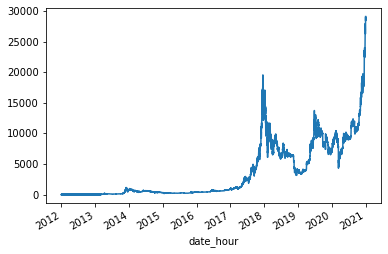

In [341]:
df.price.plot()

In [342]:
df = df.loc['2014-01-01':]

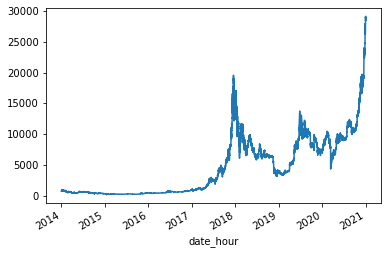

In [343]:
df.price.plot()

In [344]:
df_p = df[df.price.isna() == False]
df_last_day = df_p.iloc[-25:]

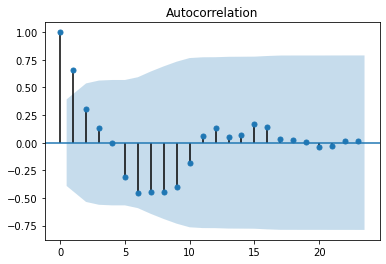

In [345]:
plot_acf(df_last_day.price, lags=23)
plt.show()

In [346]:
df_d = df_p.resample('D').sum()
df_d.index.name = 'date'
df_last_m = df_d.iloc[-30:]

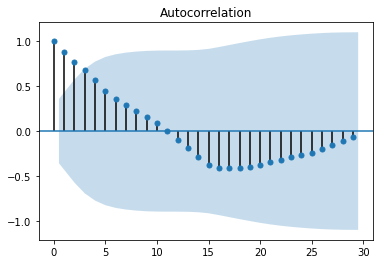

In [347]:
plot_acf(df_last_m.price, lags=29)
plt.show()

In [424]:
df_d['log_return'] = np.log(df_d.price/df_d.price.shift(1))

E:\PythonAnaconda\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


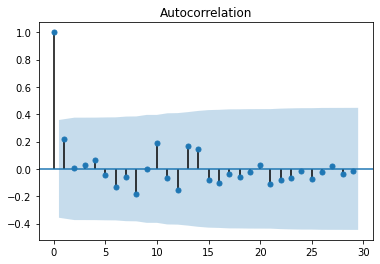

In [425]:
df_last_m_log = df_d.iloc[-30:]
plot_acf(df_last_m_log.log_return, lags=29)
plt.show()

In [426]:
df_d['abs_price_change'] = np.abs(df_d.price - df_d.price.shift(1))
df_d['per_price_change'] = (df_d.price-df_d.price.shift(1))/df_d.price.shift(1)
df_d.replace([np.inf, -np.inf], np.nan, inplace=True)

In [427]:
df_d = df_d.iloc[1:]
df_d_z = df_d.fillna(0)
df_d_z[np.isneginf(df_d_z)] = 0

In [428]:
df_d = df_d.fillna(df_d_z.rolling(30).mean())

In [429]:
np.corrcoef(df_d.log_return.values[:30],df_d.abs_price_change.values[:30])

array([[1.        , 0.07786949],
       [0.07786949, 1.        ]])

In [430]:
np.corrcoef(df_d.log_return.values[:30],df_d.per_price_change.values[:30])

array([[1.        , 0.99963633],
       [0.99963633, 1.        ]])

In [431]:
np.corrcoef(df_d.abs_price_change.values[:30],df_d.per_price_change.values[:30])

array([[1.        , 0.10391839],
       [0.10391839, 1.        ]])

In [432]:
pd.concat((df_d.corrwith(df_d['log_return']).rename('log_ret_corr').to_frame(),df_d.corrwith(df_d['abs_price_change']).rename('abs_corr').to_frame(),
df_d.corrwith(df_d['per_price_change']).rename('per_corr').to_frame(),df_d.corrwith(df_d['price']).rename('price_corr').to_frame()),axis=1)

,log_ret_corr,abs_corr,per_corr,price_corr
null_sent,NaN,NaN,NaN,NaN
null_received,0.012041,0.280384,0.002033,0.434763
0_sent,0.020971,-0.099598,0.007178,-0.291106
0_received,0.021188,-0.103635,0.007381,-0.295340
1_sent,0.012784,0.003864,0.004997,-0.020488
1_received,0.012504,0.003742,0.004929,-0.021722
2_sent,-0.003616,0.180887,-0.004690,0.343526
2_received,-0.003649,0.180881,-0.004705,0.343561
3_sent,0.009073,0.045739,-0.001502,0.026513
3_received,0.033506,0.109339,0.007080,0.033495


<ipython-input-247-7209aea8ad37>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


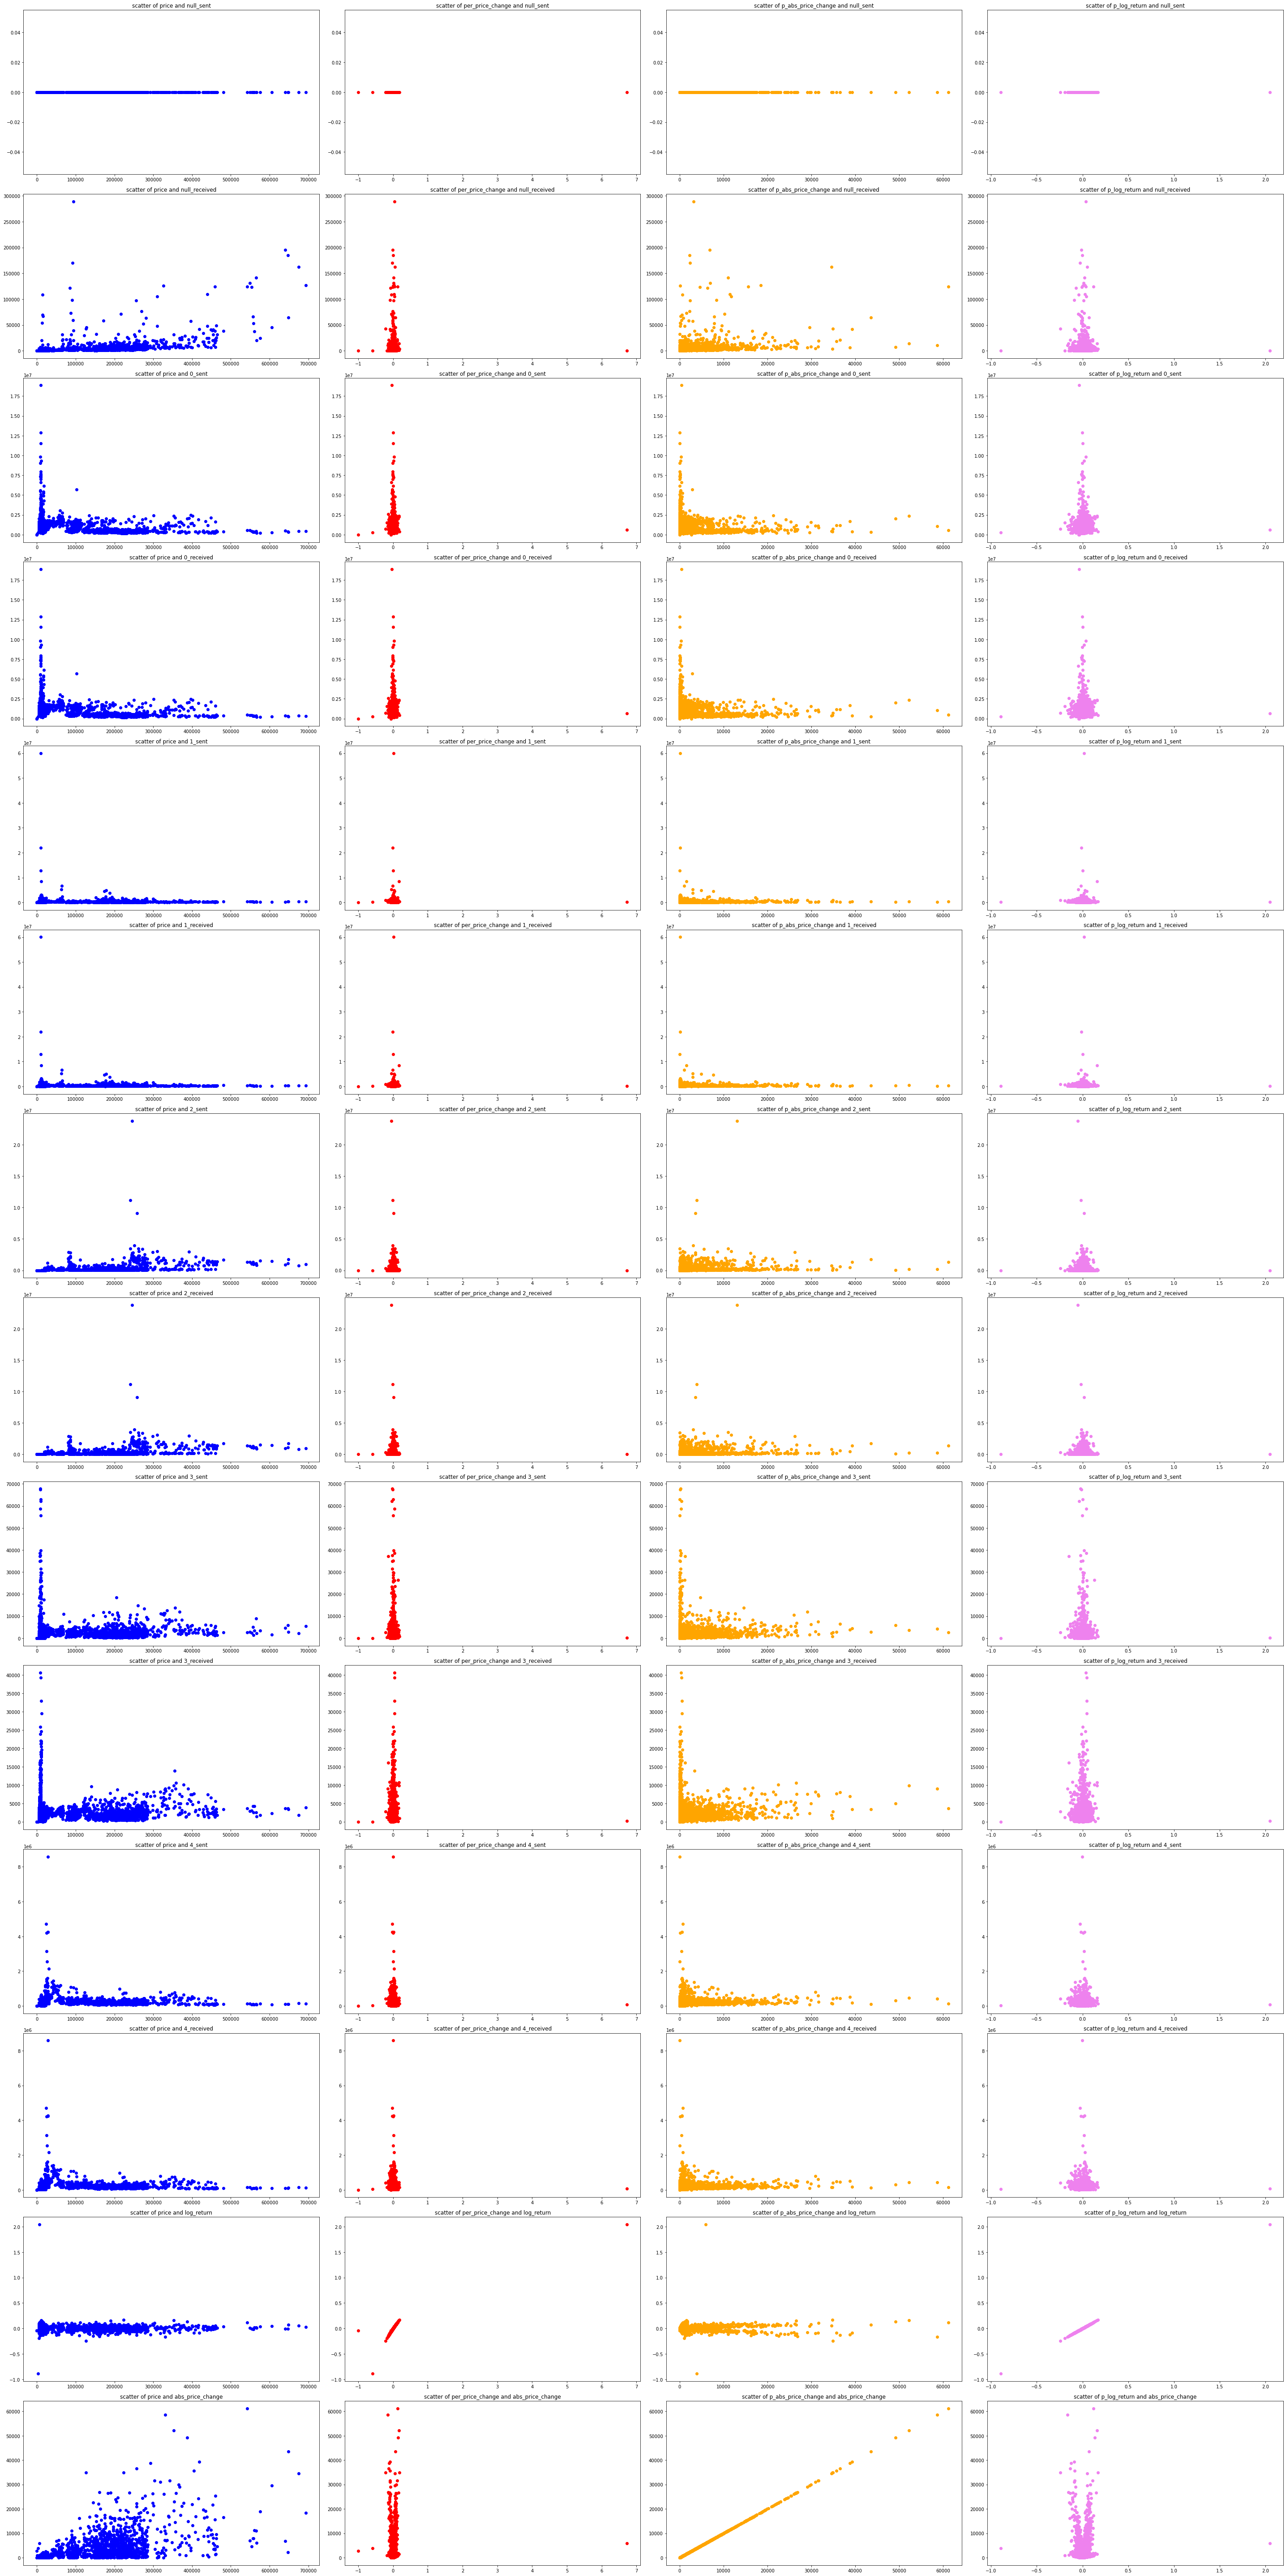

In [247]:
df_d['p_abs_price_change'] = df_d['abs_price_change']
df_d['p_log_return'] = df_d['log_return']
colors = ['blue','red','orange','violet']
x = df_d.loc[:,df_d.columns.str.startswith('p')].values
xs = df_d.loc[:,df_d.columns.str.startswith('p')].columns
cols = df_d.loc[:,~df_d.columns.str.startswith('p')].columns
fig,axs = plt.subplots(df_d.shape[1]-4,4,figsize=(40,80))
for i in range(4):
    for j,col in zip([*range(df_d.shape[1]-4)],cols):
            axs[j,i].scatter(x[:,i],df_d[col].values,color=colors[i])
            axs[j,i].set_title(f'scatter of {xs[i]} and {col}')
fig.tight_layout()
fig.show()

In [262]:
df_d.drop(columns=df_d.loc[:,df_d.columns.str.startswith('p_')].columns.tolist(),inplace=True)

In [433]:
def normalize_roll(df1):
    df = df1.copy()
    for col in df.drop(columns=['log_return']).columns:
        df[col] = (df[col]-df[col].rolling(5).mean())/df[col].rolling(5).std()
    return df

In [477]:
df_n = normalize_roll(df_d)

In [478]:
df_n = df_n.loc['2014-01-10':]
df_n = df_n.fillna(0)

In [479]:
df_n = pd.concat((df_n,pd.DataFrame(np.abs(df_n.loc[:,df_n.columns.str.endswith('received')].values - \
                                           df_n.loc[:,df_n.columns.str.endswith('sent')].values), 
                    columns = ['null_abs_diff','0_abs_diff','1_abs_diff','2_abs_diff','3_abs_diff','4_abs_diff'], 
                                    index = df_n.index)), axis = 1)

<ipython-input-479-20c293005e65>:1: RuntimeWarning: invalid value encountered in subtract
  df_n = pd.concat((df_n,pd.DataFrame(np.abs(df_n.loc[:,df_n.columns.str.endswith('received')].values - \


In [480]:
df_n = pd.concat((df_n,pd.DataFrame(np.abs(1-df_n.loc[:,df_n.columns.str.endswith('received')].values/ \
                                           df_n.loc[:,df_n.columns.str.endswith('sent')].values), 
                    columns = ['null_per_diff','0_per_diff','1_per_diff','2_per_diff','3_per_diff','4_per_diff'], 
                                    index = df_n.index)), axis = 1)

<ipython-input-480-c91cc02ece3b>:1: RuntimeWarning: divide by zero encountered in true_divide
  df_n = pd.concat((df_n,pd.DataFrame(np.abs(1-df_n.loc[:,df_n.columns.str.endswith('received')].values/ \
<ipython-input-480-c91cc02ece3b>:1: RuntimeWarning: invalid value encountered in true_divide
  df_n = pd.concat((df_n,pd.DataFrame(np.abs(1-df_n.loc[:,df_n.columns.str.endswith('received')].values/ \


In [481]:
df_n.drop(columns=['null_sent','null_per_diff'],inplace=True)

In [482]:
df_n = df_n.fillna(0)

In [483]:
df_n.drop(columns=['price','per_price_change'],inplace=True)

In [484]:
lagsN = lambda x, n: pd.concat([x.shift(z).rename('%s_lag%d' % (x.name, z)) for z in range(1,n+1)], axis=1)

In [485]:
for col in df_n.columns:
    df_n = pd.concat((df_n,lagsN(df_n[col], 5)),axis=1)

In [508]:
df_n.dropna(axis=0,inplace=True)

In [487]:
df_n = df_n.rename(columns={'log_return':'target'}) 

In [488]:
df_n.drop(columns=['abs_price_change'], inplace = True)

In [ ]:
for i in df_n.columns:
    print(i)

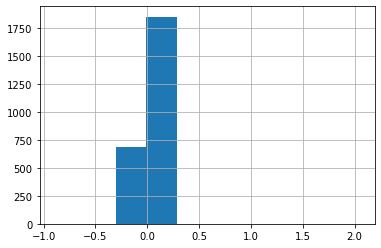

In [490]:
df_n.target.hist()

In [491]:
np.where(df_n.target>(df_n.target.mean()+df_n.target.std()/4))[0].size

652

In [492]:
np.where(df_n.target<df_n.target.mean()-df_n.target.std()/4)[0].size

647

In [493]:
df_n['target'] = df_n.target.apply(lambda x: 1 if x > (df_n.target.mean() + df_n.target.std()/4) else -1 
                                if x < (df_n.target.mean() - df_n.target.std()/4) else 0)

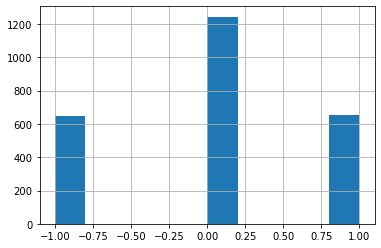

In [494]:
df_n['target'].hist()

In [495]:
from sklearn.ensemble import RandomForestClassifier

In [510]:
df_n.replace([np.inf, -np.inf], np.nan, inplace=True)
df_n.dropna(axis=0,inplace=True)

In [511]:
X = df_n.drop(columns=['target']).values
y = df_n.target

In [512]:
rf = RandomForestClassifier().fit(X,y)

In [516]:
rf.score(X,y)

1.0

Text(0.5, 1.0, 'feature importances')

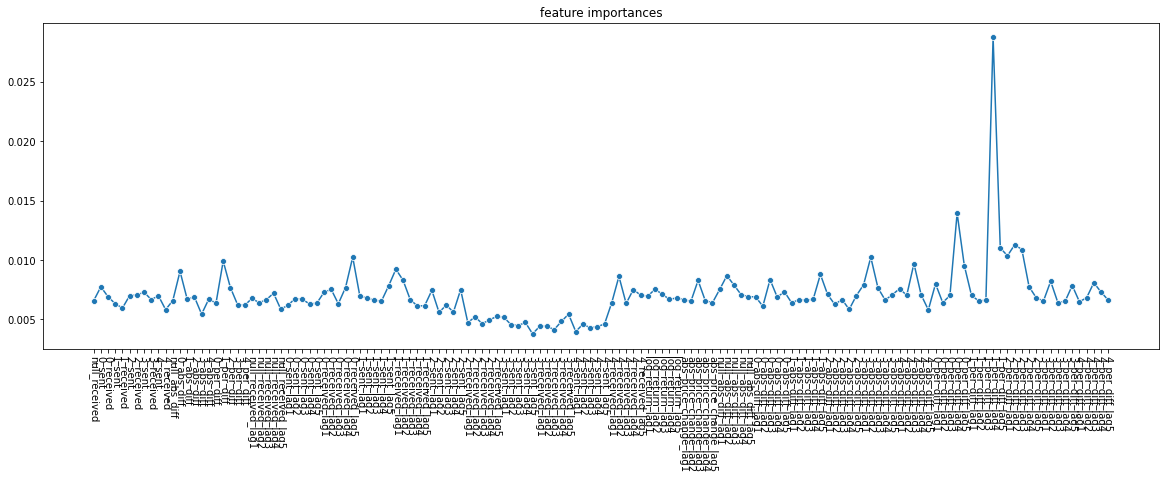

In [528]:
plt.figure(figsize = (20,6))
fig = sns.lineplot(x = df_n.drop(columns=['target']).columns.tolist(),y = rf.feature_importances_,marker="o")
fig.set_xticklabels(df_n.drop(columns=['target']).columns.tolist(),rotation=-90)
fig.set_title("feature importances")

In [526]:
df_n.drop(columns=['target']).columns.tolist()[np.argmax(rf.feature_importances_)]

'log_return_lag1'

In [558]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import balanced_accuracy_score, accuracy_score, make_scorer

In [542]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.25)

In [559]:
acc = make_scorer(balanced_accuracy_score)

In [574]:
import warnings
warnings.filterwarnings("ignore")
cross_val_score(XGBClassifier(eval_metric='merror', sampling_method='gradient_based', max_depth=7, 
                             eta=0.1, min_child_weight=2,), X_train, y_train, scoring=acc)

array([0.39474231, 0.4289942 , 0.39479396, 0.39100495, 0.4630938 ])

### <font color='red'> BRUH. lets try another approach

In [837]:
df_4 = df.resample('4H').sum()

In [838]:
df_autorocc_test = df_4.iloc[-30:]

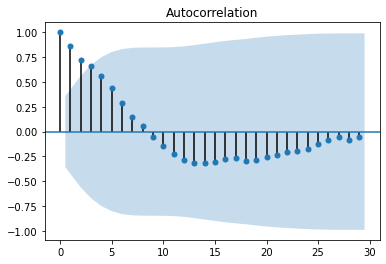

In [839]:
plot_acf(df_autorocc_test.price, lags=29)
plt.show()

In [840]:
def double_exponential_smoothing(series, alpha=0.3, beta=0.1):
    result = [series[0]]
    for n in range(1, len(series)): 
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): 
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [841]:
def volatility(price, lag_price, period, ema): # pass two pd.Series and wanted period in str
    # substract ema from lagged returns, rise to pow 2 and sum up over the chosen period
    nominator = ((lag_price - ema(price))**2).rolling(period).sum()
    denominator = lag_price.rolling(period).count()-1 
    return np.sqrt(nominator/denominator)

In [842]:
df_4['lag_price'] = df_4.price.shift(1)
df_4.dropna(axis=0,inplace=True)
df_4['volatility'] = volatility(df_4['price'],df_4['lag_price'],3,double_exponential_smoothing)
df_4.dropna(axis=0,inplace=True)
df_4['volatility'].isna().sum()
df_4.dropna(axis=0,inplace=True)
df_4['target'] = df_4.apply(lambda x: 1 if x.price > x.lag_price + x.volatility/2 else -1 
                           if x.price < x.lag_price - x.volatility/2 else 0, axis=1)

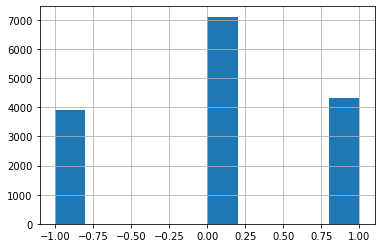

In [843]:
df_4['target'].hist()

In [844]:
df_4 = df_4.drop(columns=['price','lag_price','volatility','null_sent'])

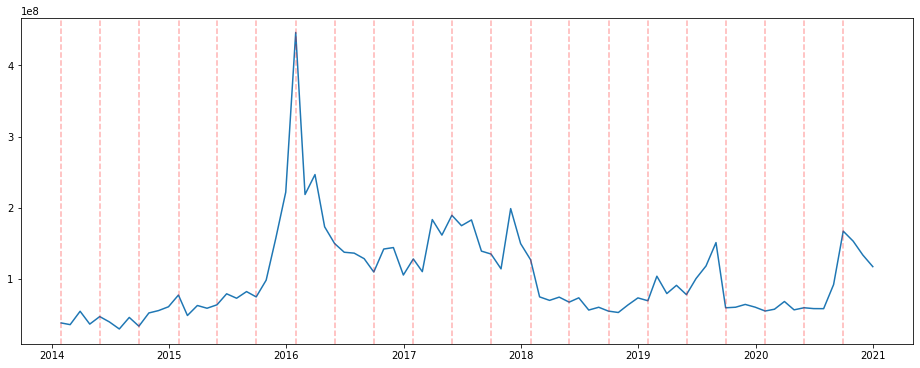

In [845]:
plt.figure(figsize=(16,6))
plt.plot(df_4.resample('M').sum().sum(axis=1))
for month in pd.date_range(df_4.index[0],df_4.index[-1],freq='4M'):
    plt.axvline(month, linestyle='--',color='red',alpha=0.3)

In [867]:
def normalize_roll(df,period):
    df_test = df.copy()
    df_test = (df_test-df_test.rolling(period).mean())/df_test.rolling(period).std()
    return df_test

In [882]:
df_n = normalize_roll(df_4.drop(columns=['target']),240)

In [883]:
df_n['target'] = df_4.target

In [885]:
df_n = df_n.fillna(df_n.fillna(0).rolling(240).apply(np.nanmean))

In [886]:
df_n.dropna(inplace=True)

In [922]:
for col in df_n.columns:
    df_n = pd.concat((df_n,lagsN(df_n[col], 3)),axis=1)

In [925]:
df_n.dropna(inplace=True)
df_n.drop(columns=['target_lag1','target_lag2','target_lag3'],inplace=True)

In [927]:
X,y = df_n.drop(columns=['target']).values, df_n['target']

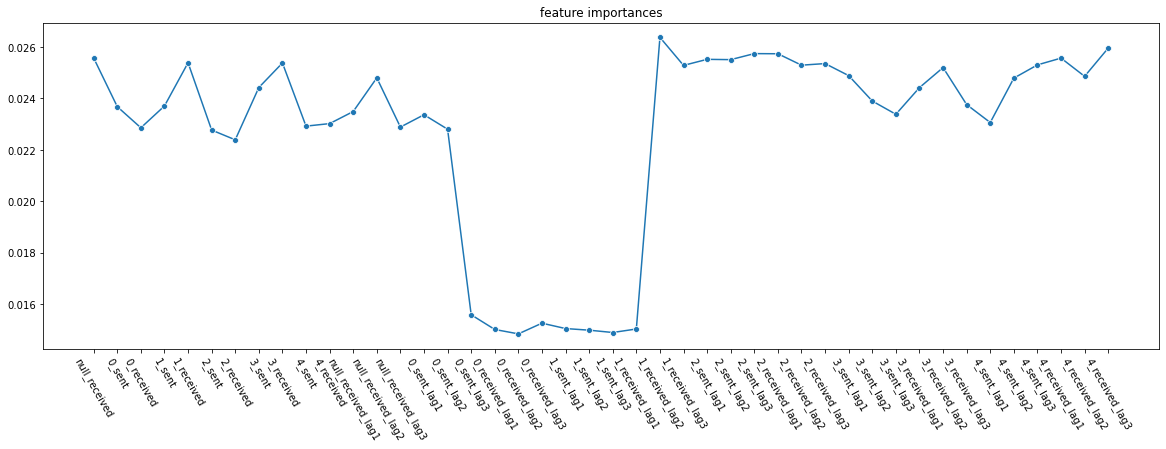

1.0
0.3361246682109025


In [928]:
rf = RandomForestClassifier(max_depth=100).fit(X,y)
plt.figure(figsize = (20,6))
fig = sns.lineplot(x = df_n.drop(columns=['target']).columns.tolist(),y = rf.feature_importances_,marker="o")
fig.set_xticklabels(df_n.drop(columns=['target']).columns.tolist(),rotation=-60)
fig.set_title("feature importances")
plt.show()
print(rf.score(X,y))
print(np.mean(cross_val_score(RandomForestClassifier(max_depth=100), X, y, scoring=acc)))

In [929]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

In [959]:
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3, 4, 5, 6]
        }


xgb = XGBClassifier(learning_rate=0.02, n_estimators=600)

skf = StratifiedKFold(n_splits=4, shuffle = False)

In [960]:
#random_search = GridSearchCV(xgb, params, scoring=acc, cv=skf.split(X,y)) useless

In [ ]:
def custom_grid_search_cv(estimator,grid,n_folds,X,y):
    cv = np.linspace(0.2,1,n_folds)
    mean_acc_for_param = []
    params = list(ParameterGrid(grid))
    i = 1
    j = len(params)
    for par in params:
        mean_acc_for_cv = []
        estimator.set_params(**par)
        for c in cv:
            X_ = X.iloc[:int(len(X)*c)]
            y_ = y[:int(len(y)*c)]
            X_train,X_test,y_train,y_test = train_test_split(X_,y_,shuffle=False,test_size=0.33)
            rf = estimator.fit(X_train,y_train)
            pred = rf.predict(X_test)
            mean_acc_for_cv.append(accuracy_score(y_test,pred))
        mean_acc_for_param.append(np.mean(mean_acc_for_cv))
        print(f'{i} parameters setup done, {j-i} left, avg weighted accuracy score is: {mean_acc_for_param[i-1]}')
        i+=1
    return params[mean_acc_for_param.index(max(mean_acc_for_param))], max(mean_acc_for_param)

In [ ]:
grid = {'bootstrap': [True],
 'n_estimators' : [40,50,60],
 'max_depth': [15, 20, 25, 30, 40],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5]}
estimator = RandomForestClassifier(class_weight='balanced_subsample')

In [ ]:
best_params, best_score = custom_grid_search_cv(estimator,grid,5,X,y) 